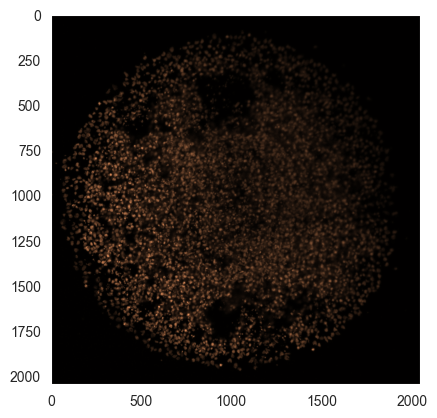

In [52]:
from micropattern_analysis import *
import imageio.v3 as iio
import matplotlib.pyplot as plt
import numpy as np

files = [file for file in gather_files("C:/Users/flori/OneDrive - Universität Wien/Adameyko Lab/FS1_MP_ISTA_MIFF1/") if
         "ISL" not in file]
img = iio.imread(files[-1])
plt.imshow(img[0][0], cmap="gray")
plt.imshow(img[0][1], cmap="copper")
plt.grid(False)
plt.show()

In [22]:
edu, dapi = np.argmax(np.sum(np.sum(img, axis=2), axis=2), axis=0)

In [67]:
from skimage.filters import threshold_li, threshold_isodata, threshold_sauvola, threshold_niblack
from skimage.morphology import white_tophat, black_tophat

edu_image = img[edu][0]
dapi_image = img[dapi][1]

edu_image = edu_image > threshold_li(edu_image)
dapi_image = dapi_image > threshold_li(dapi_image)

edu_count = np.count_nonzero(edu_image)
dapi_count = np.count_nonzero(dapi_image)
total_count = np.count_nonzero(edu_image * dapi_image)

#plt.imshow(dapi_image, cmap="gray_r")
#plt.show()
print(dapi_count, edu_count)

1486807 1014645


In [76]:
from skimage.filters import threshold_li
import os

path = "C:/Users/flori/OneDrive - Universität Wien/Adameyko Lab/FS1_MP_ISTA_MIFF1/"
time = []
ratio = []
for file in gather_files(path):
    if "ISL" not in file:
        img = iio.imread(file)

        edu, dapi = np.argmax(np.sum(np.sum(img, axis=2), axis=2), axis=0)
        edu_image = img[edu][0]
        dapi_image = img[dapi][1]

        edu_image = edu_image > threshold_li(edu_image)
        dapi_image = dapi_image > threshold_li(dapi_image)

        edu_count = np.count_nonzero(edu_image)
        dapi_count = np.count_nonzero(dapi_image)
        total_count = np.count_nonzero(edu_image * dapi_image)

        time.append(f"{os.path.basename(os.path.dirname(file))}")
        ratio.append(total_count / dapi_count)
dic = {
    "time": time,
    "ratio": ratio
}

In [ ]:
# TODO: compare positive edu pixels to normal image
# TODO: number of dapi positive pixels vs. time
# TODO: compare unedited edu images vs. time
# TODO: edu distance from center
# TODO: compare this with distances of other zones

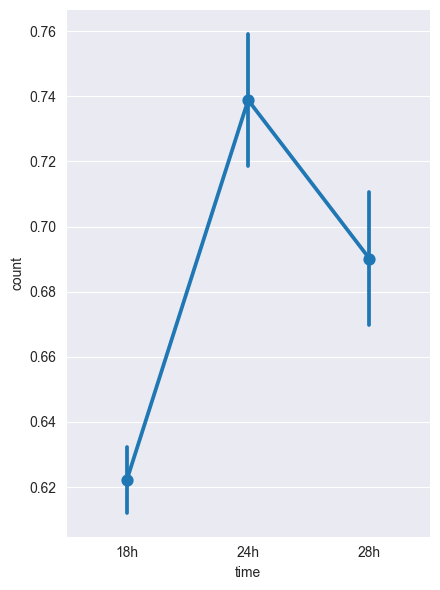

In [77]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(dic)
sns.catplot(df, x="time", y="count", errorbar="se",
    kind="point", height=6, aspect=.75)

### Preprocessing

In [34]:
from micropattern_analysis import *
from support_functions import *

from toolz import pipe

In [2]:
dir = r"D:\OneDrive - Universität Wien\Adameyko Lab\FS1_MP_ISTA_MIFF1"
os.chdir(dir)
dirs = os.listdir(".")
print(dirs)

['18h', '24h', '28h', 'Control']


In [4]:
dirs = dirs[0:3]
print(dirs)

['18h', '24h', '28h']


In [6]:
file_names, images = zip(*get_files_and_images(dirs).items())

In [21]:
dapi_num = 1

v_new = list(map(
    lambda x:
    pipe(
        x,
        lambda f: maximise_and_normalize(f),
        lambda f: apply_multiotsu_to_image(f, dapi_num),
    ),
    images[2:])
)

print(f'Original shape:\t{images[2].shape}')
print(f'New shape:\t{v_new[0].shape}')

Original shape:	(4, 1024, 1024)
New shape:	(2, 2048, 2048)


### Image Processing

In [28]:
def time_point(file):
    file_params = os.path.basename(file).split("_")
    return file_params[3]

In [29]:
df = []
channel_names = ["EdU", "DAPI"]

for file, img in zip(file_names[2:], v_new):
    df_mini = generate_data_frame(
        expand_coordinate_matrix(img[dapi_num]),
        img,
        channel_names,
        Distances=get_distances(img[dapi_num])
    )
    df_mini = scale_distances(df_mini, file=file)
    df_mini = group_distances(df_mini, channel_names)
    df_mini["Time"] = np.repeat(time_point(file), df_mini.shape[0])
    df.append(df_mini)

df = pd.concat(df)

### Analysis

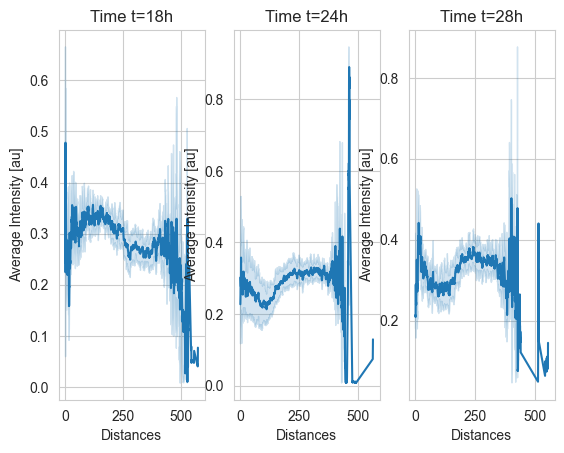

In [30]:
fig, axes = plt.subplots(1, 3)

time_points = ["18h", "24h", "28h"]

for ax, t in zip(axes.flat, time_points):
    df_sub = df[df["Time"] == t]
    df_sub.reset_index(inplace=True)
    sns.lineplot(df_sub, x="Distances", y="EdU", ax=ax)
    ax.set_ylabel("Average Intensity [au]") 
    ax.set_title(f"Time t={t}")

In [40]:
df["Total"] = df["EdU"] * df["DAPI"]
df["Total Average"] = df["Total"] / df["DAPI"]

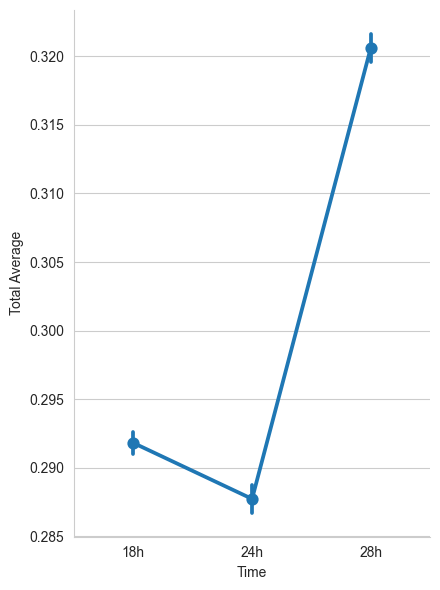

In [42]:
sns.catplot(df, x="Time", y="Total Average", errorbar="se",
    kind="point", height=6, aspect=.75)

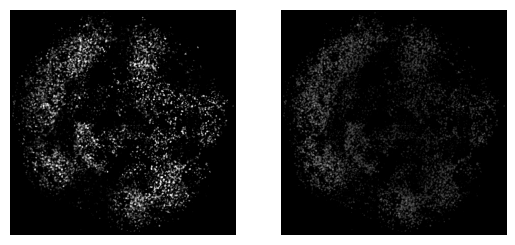

In [35]:
fig, axes = plt.subplots(1, 2)

plot_all_channels(axes, v_new[0])

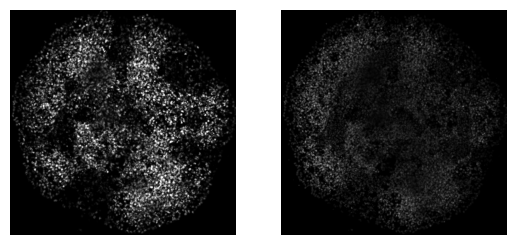

In [37]:
fig, axes = plt.subplots(1, 2)

plot_all_channels(axes, maximise_and_normalize(images[2]))